

Descargo el dataset con las reviews en la categoría Pet supplies



In [ ]:
!pip install wordcloud

     -------------------------------------- 300.6/300.6 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

def calcular_cardinalidad_vocabulario(texto):
    palabras = word_tokenize(texto.lower())  # Tokenizar el texto y convertirlo a minúsculas
    return len(set(palabras))

def obtener_ngrams(texto, n=2, num=10):
    palabras = word_tokenize(texto.lower())
    n_grams = [tuple(palabras[i:i+n]) for i in range(len(palabras)-n+1)]
    frecuencia = FreqDist(n_grams)
    return frecuencia.most_common(num)

def analisis_sentimiento_basado_en_reglas(texto, sentimiento1, sentimiento2):

    # Contar la frecuencia de palabras clave en el texto
    frecuencia_positivas = sum(texto.lower().count(palabra) for palabra in sentimiento1)
    frecuencia_negativas = sum(texto.lower().count(palabra) for palabra in sentimiento2)

    # Calcular el puntaje de sentimiento
    puntaje_sentimiento = frecuencia_positivas - frecuencia_negativas

    # Definir umbrales de clasificación
    umbral_positivo = 1
    umbral_negativo = -1

    # Clasificar la revisión
    if puntaje_sentimiento > umbral_positivo:
        return "Positivo"
    elif puntaje_sentimiento < umbral_negativo:
        return "Negativo"
    else:
        return "Neutral"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Esta casilla solo ejecutar si es en Colab
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Pet_Supplies_5.json.gz

--2024-04-07 13:44:42--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Pet_Supplies_5.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306131006 (292M) [application/x-gzip]
Saving to: ‘Pet_Supplies_5.json.gz’

Pet_Supplies_5.json 100%[===================>] 291.95M  21.7MB/s    in 12s     

2024-04-07 13:45:03 (23.7 MB/s) - ‘Pet_Supplies_5.json.gz’ saved [306131006/306131006]



In [ ]:
datos = pd.read_json("Pet_Supplies_5.json.gz", lines=True, chunksize=50000)
datos = pd.concat(datos)
print(datos.shape)
datos.head()

(2098325, 12)


,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,3,2,True,"12 2, 2016",A2KN4FJVI2TZSF,0972585419,M.G.,I purchased this cd for my Pocket Parrot. It h...,It's okay,1480636800,NaN,NaN
1,3,NaN,True,"10 17, 2016",A3RMA1DD66JDRV,0972585419,Susan P.,"Maybe it's just my Amazon parrot, but she's no...",It might work for a different bird,1476662400,NaN,NaN
2,5,2,True,"09 9, 2016",AAANYRIEOIT3R,0972585419,Luggie Lugnut,I bought this to help me teach my blue quaker ...,I bought this to help me teach my blue quaker ...,1473379200,NaN,NaN
3,3,NaN,True,"08 31, 2016",A3W44VX0LXAOHU,0972585419,Melissa Partin,Bird showed no interest in it....,Three Stars,1472601600,NaN,NaN
4,2,NaN,True,"08 18, 2016",A16ZDBZGKYDRSU,0972585419,Cheryle Bell,Didn't do a thing for my African Grey! He hate...,He hated it and it was very obnoxious,1471478400,NaN,NaN


In [ ]:
variables_seleccionadas = ["overall", "reviewerName", "reviewText", "summary"]
datos = datos.sample(n=50000, random_state=42)
datos = datos[variables_seleccionadas]
datos.dropna(subset=['reviewText'], inplace=True)
print(datos.shape)
datos.head()

(49988, 4)


,overall,reviewerName,reviewText,summary
1055801,5,Noel,The large harness on its smallest settings fit...,EzyDog makes the best dog harness
2080252,5,Laurie L. Jarvis,received,Five Stars
1814786,5,Pamela U. Moore,"This is the only product like this, that my ol...",The only one that helps
1167559,5,Cathy H.,I needed a carrier for a stray cat I've been f...,Perfect carrier.
1917418,5,Anonymous,Well made - some of my dogs favorite toys. I h...,Five Stars


In [ ]:
datos['cardinalidad_vocabulario'] = datos['reviewText'].apply(calcular_cardinalidad_vocabulario)
datos.head()

,overall,reviewerName,reviewText,summary,cardinalidad_vocabulario
1055801,5,Noel,The large harness on its smallest settings fit...,EzyDog makes the best dog harness,78
2080252,5,Laurie L. Jarvis,received,Five Stars,1
1814786,5,Pamela U. Moore,"This is the only product like this, that my ol...",The only one that helps,41
1167559,5,Cathy H.,I needed a carrier for a stray cat I've been f...,Perfect carrier.,91
1917418,5,Anonymous,Well made - some of my dogs favorite toys. I h...,Five Stars,16


In [ ]:
# Calcular la media de la cardinalidad del vocabulario
media_cardinalidad = round(datos['cardinalidad_vocabulario'].mean(),2)

# Imprimir la media de la cardinalidad del vocabulario
print("La media de la cardinalidad del vocabulario es:", media_cardinalidad)

La media de la cardinalidad del vocabulario es: 37.56


In [ ]:
distribucion_estrellas = datos['overall'].value_counts().sort_index()
print("Distribución de reviews por número de estrellas:")
print(distribucion_estrellas)

Distribución de reviews por número de estrellas:
overall
1     3273
2     2528
3     4273
4     6941
5    32973
Name: count, dtype: int64


In [ ]:
num_positivas = datos[datos['overall'] >= 4].shape[0] # Tomo que 4 y 5 estrellas son positivas y 1 ,2 son más bien negativas
num_negativas = datos[datos['overall'] <= 2].shape[0]
print("Número de reviews positivas:", num_positivas)
print("Número de reviews negativas:", num_negativas)

Número de reviews positivas: 39914
Número de reviews negativas: 5801


In [ ]:
ngrams_frecuentes = obtener_ngrams(datos['reviewText'].str.cat(sep=' '))
print("N-grams más frecuentes:")
print(ngrams_frecuentes)

N-grams más frecuentes:
[(('.', 'i'), 27728), (('.', 'the'), 10080), (('.', 'it'), 9790), ((',', 'but'), 9436), (('.', 'my'), 8649), ((',', 'and'), 8510), (('it', '.'), 7626), (('it', "'s"), 7566), (('i', 'have'), 7336), (('of', 'the'), 7182)]


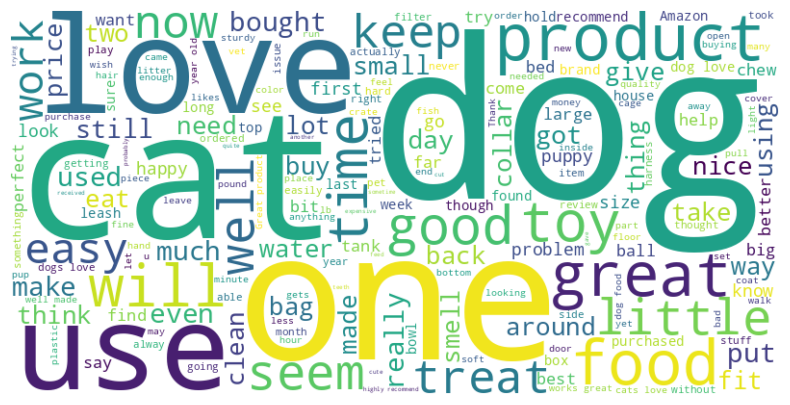

In [ ]:
texto_completo = ' '.join(datos['reviewText'])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_completo)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

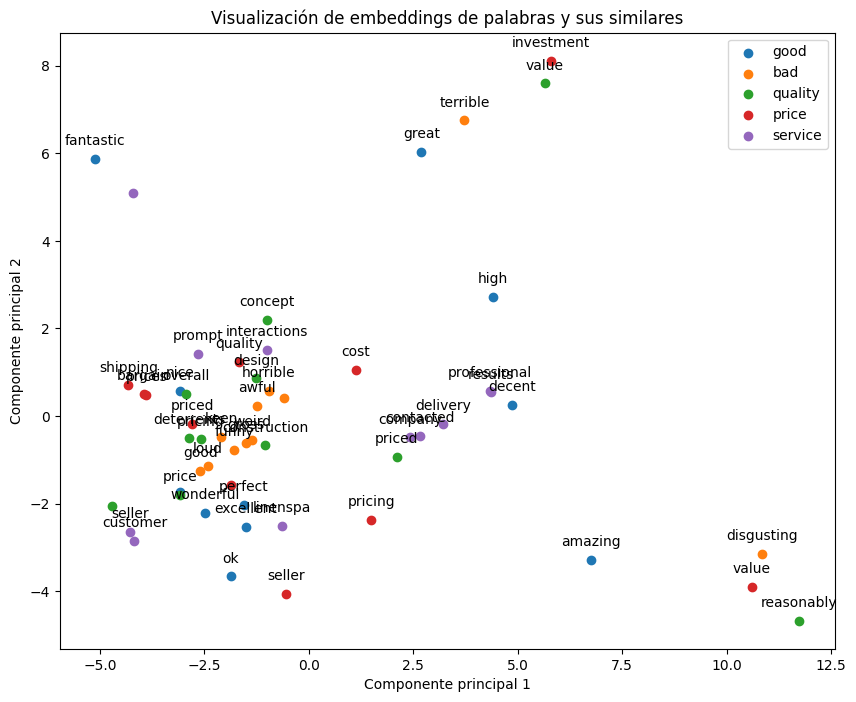

In [ ]:


# Tokenizar las revisiones
tokenized_reviews = [word_tokenize(review.lower()) for review in datos['reviewText']]

# Entrenar el modelo Word2Vec
model = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Seleccionar algunas palabras de interés
palabras_interes = ['good', 'bad', 'quality', 'price', 'service']

# Obtener las palabras más similares a cada palabra de interés
palabras_similares = {}
for palabra in palabras_interes:
    similares = model.wv.most_similar(palabra, topn=10)
    palabras_similares[palabra] = similares

# Obtener los embeddings de las palabras de interés y sus similares
palabras_embeddings = {}
for palabra in palabras_interes:
    similares = [palabra] + [sim[0] for sim in palabras_similares[palabra]]
    embeddings = [model.wv[p] for p in similares]
    palabras_embeddings[palabra] = embeddings

# Reducir la dimensionalidad a 2 dimensiones utilizando PCA

pca = PCA(n_components=2)
palabras_embeddings_pca = {palabra: pca.fit_transform(embeddings) for palabra, embeddings in palabras_embeddings.items()}


# Graficar las palabras en 2 dimensiones

plt.figure(figsize=(10, 8))
for palabra, embeddings in palabras_embeddings_pca.items():
    plt.scatter(embeddings[:, 0], embeddings[:, 1], label=palabra)
    for i, (x, y) in enumerate(embeddings):
        # Verificar que haya suficientes palabras similares disponibles
        if i < len(palabras_similares[palabra]):
            plt.annotate(palabras_similares[palabra][i][0], (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Visualización de embeddings de palabras y sus similares')
plt.legend()
plt.show()

In [ ]:
# Para el análisis de sentimiento voy a ver la polaridad más específicos de estos reviews
palabras_positivas = ["good", "favourite", "great","amazing", "happy"]
palabras_negativas = ["bad", "terrible", "awful", "disgusting","sad"]
sentimientos_positivos = {}
sentimientos_negativos = {}

for buenas in palabras_positivas:
    similares_p = model.wv.most_similar(buenas, topn=20)
    sentimientos_positivos[buenas] = similares_p
for negativas in palabras_negativas:
    similares_n = model.wv.most_similar(negativas, topn=20)
    sentimientos_negativos[negativas] = similares_n

palabras_embeddings_positivas = {}
palabras_embeddings_negativas = {}

for positivas in palabras_positivas:
    similares_p = [positivas] + [sim[0] for sim in sentimientos_positivos[positivas]]
    embeddings_p = [model.wv[p] for p in similares_p]
    palabras_embeddings_positivas[positivas] = embeddings_p

for negativas in palabras_negativas:
    similares_n = [negativas] + [sim[0] for sim in sentimientos_negativos[negativas]]
    embeddings_n = [model.wv[p] for p in similares_n]
    palabras_embeddings_negativas[negativas] = embeddings_n


In [ ]:
# He definido una función basada en reglas
datos["sentimiento"] = datos["reviewText"].apply(lambda x: analisis_sentimiento_basado_en_reglas(x, palabras_embeddings_positivas, palabras_embeddings_negativas))
datos.head()

,overall,reviewerName,reviewText,summary,cardinalidad_vocabulario,sentimiento
1055801,5,Noel,The large harness on its smallest settings fit...,EzyDog makes the best dog harness,78,Neutral
2080252,5,Laurie L. Jarvis,received,Five Stars,1,Neutral
1814786,5,Pamela U. Moore,"This is the only product like this, that my ol...",The only one that helps,41,Neutral
1167559,5,Cathy H.,I needed a carrier for a stray cat I've been f...,Perfect carrier.,91,Neutral
1917418,5,Anonymous,Well made - some of my dogs favorite toys. I h...,Five Stars,16,Neutral


In [ ]:
frecuencia_sentimientos = datos["sentimiento"].value_counts()

# Mostrar los resultados
print("Número de registros de cada sentimiento:")
print(frecuencia_sentimientos)

Número de registros de cada sentimiento:
sentimiento
Neutral     46602
Positivo     3293
Negativo       93
Name: count, dtype: int64


## Conclusiones a la exploración

- Por un lado veo que la media de cardinalidad de las reviews es de 37, 5 palabras únicas
- Que la distribución de las estrellas me indican que hay más comentarios positivos que negativos y esto se vuelve a constatar con el número de reviews positivas y negativas
- Con lo n-grams me doy cuenta de que voy a tener que preprocesar los datos, ya que de momentos son las conjunciones que se repiten más a menudo junto con los espacios
- En la nube de palabras queda claro que la categoría del dataset va sobre mascotas
- Con el Word2Vec veo que la asociación de "seller" y "value" con "price" y "quality", sugiere conexiones semánticas entre estas palabras. La relación de "terrible" con "bad" y la asociación de palabras como "wonderful", "great" y "high" con "good" indican la polaridad de las que tienen las reviews
- Por último creé una función para valorar el sentimiento general de la review y me doy cuenta que la mayoría dan sentimientos neutros

# Preprocesado

In [ ]:
import string
import nltk
import pandas as pd
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def preprocesar_reviews(review):
    review = eliminar_puntuacion(review)
    review = convertir_minusculas(review)
    review = eliminar_stopwords(review)
    review = stem_palabras(review)
    return review

def eliminar_puntuacion(texto):
    translator = str.maketrans('', '', string.punctuation)
    return texto.translate(translator)

def convertir_minusculas(texto):
    return texto.lower()

def eliminar_stopwords(texto):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(texto)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

def stem_palabras(texto):
    ps = PorterStemmer()
    words = word_tokenize(texto)
    words = [ps.stem(word) for word in words]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
review = "This is a sample review, with punctuations and stopwords included."
review_procesada = preprocesar_reviews(review)
print("Review original:", review)
print("Review procesada:", review_procesada)

Review original: This is a sample review, with punctuations and stopwords included.
Review procesada: sampl review punctuat stopword includ


In [ ]:
# Aplico el preprocesador a las reviews
datos['reviewText'] = datos['reviewText'].apply(preprocesar_reviews)
datos.head()

,overall,reviewerName,reviewText,summary,cardinalidad_vocabulario,sentimiento
1055801,5,Noel,larg har smallest set fit perfect stubborn eng...,EzyDog makes the best dog harness,78,Neutral
2080252,5,Laurie L. Jarvis,receiv,Five Stars,1,Neutral
1814786,5,Pamela U. Moore,product like oldest cat eat seem help right aw...,The only one that helps,41,Neutral
1167559,5,Cathy H.,need carrier stray cat ive feed take vet bough...,Perfect carrier.,91,Neutral
1917418,5,Anonymous,well made dog favorit toy coupl size,Five Stars,16,Neutral


# Entrenamiento

In [ ]:
# Realizo el split con variable objetivo mi columna de sentimiento
X_train_full, X_test, y_train_full, y_test = train_test_split(datos['reviewText'], datos['sentimiento'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

print("El tamaño del conjunto de entrenamiento es: ", X_train.shape)
print("El tamaño del conjunto de validacion es: ", X_val.shape)
print("El tamaño del conjunto de test es: ", X_test.shape)

El tamaño del conjunto de entrenamiento es:  (29992,)
El tamaño del conjunto de validacion es:  (9998,)
El tamaño del conjunto de test es:  (9998,)


In [ ]:
# Creo el modelo bolsa de palabras
vectorizer = CountVectorizer(max_features=1000, binary=True)  # escogí 1000 palabras
X_train_bow = vectorizer.fit_transform(X_train)  # Ajuste y transformación en el conjunto de entrenamiento
X_val_bow = vectorizer.transform(X_val)  # Transformación en el conjunto de validación
X_test_bow = vectorizer.transform(X_test)

In [ ]:
# Primero utilizaré Regresión Logística
modelo_1 = LogisticRegression(class_weight='balanced')
modelo_1.fit(X_train_bow, y_train)

# Entreno
y_pred_val = modelo_1.predict(X_val_bow)
print("Modelo 1 (Regresión Logística) - Validación:")
print(classification_report(y_val, y_pred_val))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Modelo 1 (Regresión Logística) - Validación:
              precision    recall  f1-score   support

    Negativo       0.06      0.20      0.09        25
     Neutral       0.98      0.90      0.94      9315
    Positivo       0.37      0.77      0.50       658

    accuracy                           0.89      9998
   macro avg       0.47      0.62      0.51      9998
weighted avg       0.94      0.89      0.91      9998



Dado el desbalanceo considerable de mis datos creo conveniente aplicar una mátrica más: el area bajo la curva

Área bajo la curva ROC (AUC-ROC) para la clase Negativa: 0.6725478792740399
Área bajo la curva ROC (AUC-ROC) para la clase Positiva: 0.9401456623471294
Área bajo la curva ROC (AUC-ROC) para la clase Neutral: 0.8412362577064503


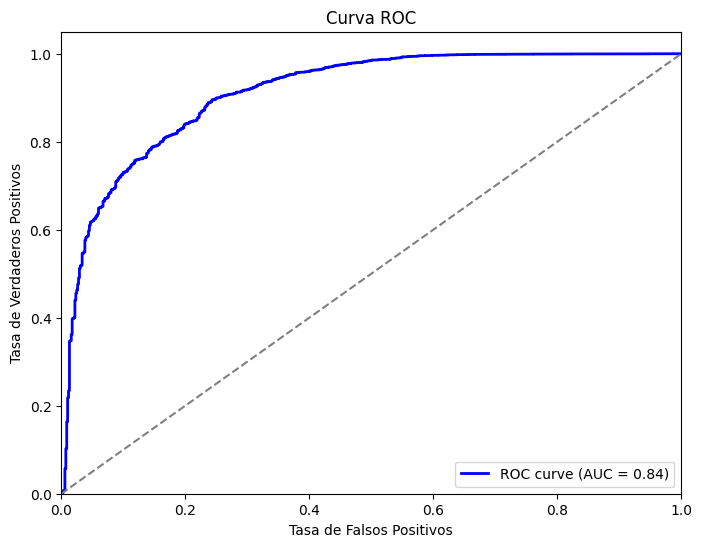

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Primero preparo mis variables objetivos a numéricos
y_train_f = y_train.replace({'Negativo': 0, 'Neutral': 1, 'Positivo': 2})
y_val_f = y_val.replace({'Negativo': 0, 'Neutral': 1, 'Positivo': 2})
y_test_f = y_test.replace({'Negativo': 0, 'Neutral': 1, 'Positivo': 2})

y_pred_proba = modelo_1.predict_proba(X_val_bow)

y_pred_proba_negative = y_pred_proba[:, 0]
y_pred_proba_positive = y_pred_proba[:, 2]

# Calcular el AUC-ROC para la clase Negativa
auc_roc_negative = roc_auc_score(y_val_f == 0, y_pred_proba_negative, multi_class='ovr')

# Calcular el AUC-ROC para la clase Positiva
auc_roc_positive = roc_auc_score(y_val_f == 2, y_pred_proba_positive, multi_class='ovr')

print("Área bajo la curva ROC (AUC-ROC) para la clase Negativa:", auc_roc_negative)
print("Área bajo la curva ROC (AUC-ROC) para la clase Positiva:", auc_roc_positive)
# Calcular el AUC-ROC
auc_roc = roc_auc_score(y_val_f, y_pred_proba, multi_class='ovr')
print("Área bajo la curva ROC (AUC-ROC) para la clase Neutral:", auc_roc)



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Primero preparo mis variables objetivos a numéricos
y_train_f = y_train.replace({'Negativo': 0, 'Neutral': 1, 'Positivo': 2})
y_val_f = y_val.replace({'Negativo': 0, 'Neutral': 1, 'Positivo': 2})
y_test_f = y_test.replace({'Negativo': 0, 'Neutral': 1, 'Positivo': 2})


X_train_bow_dense = X_train_bow.toarray()
X_val_bow_dense = X_val_bow.toarray()
X_test_bow_dense = X_test_bow.toarray()

modelo_2 = Sequential()
modelo_2.add(Embedding(input_dim=X_train_bow_dense.shape[1], output_dim=16, input_length=X_train_bow.shape[1]))
modelo_2.add(LSTM(units=64, dropout=0.5))
modelo_2.add(Dense(units=1, activation='softmax'))

# Compilo
modelo_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entreno
history = modelo_2.fit(X_train_bow_dense, y_train_f, epochs=5, batch_size=64, validation_data=(X_val_bow_dense, y_val_f))

# Evaluación
test_loss, test_accuracy = modelo_2.evaluate(X_test_bow_dense, y_test_f)
print("Accuracy en el conjunto de test:", test_accuracy)

Epoch 1/5
469/469 [==============================] - 367s 770ms/step - loss: -1.3513 - accuracy: 0.9323 - val_loss: -2.2537 - val_accuracy: 0.9317
Epoch 2/5
469/469 [==============================] - 356s 760ms/step - loss: -3.1664 - accuracy: 0.9323 - val_loss: -3.9966 - val_accuracy: 0.9317
Epoch 3/5
469/469 [==============================] - 358s 763ms/step - loss: -4.9392 - accuracy: 0.9323 - val_loss: -5.7542 - val_accuracy: 0.9317
Epoch 4/5
469/469 [==============================] - 355s 758ms/step - loss: -6.7155 - accuracy: 0.9323 - val_loss: -7.4885 - val_accuracy: 0.9317
Epoch 5/5
313/313 [==============================] - 39s 126ms/step - loss: -9.3028 - accuracy: 0.9328
Accuracy en el conjunto de test: 0.9327865839004517


In [ ]:
# también aplico el area bajo la curva a este modelo

y_pred_val_probs = modelo_2.predict(X_val_bow_dense)

y_pred_val_probs_3_classes = np.concatenate([1 - y_pred_val_probs, y_pred_val_probs, np.zeros_like(y_pred_val_probs)], axis=1)

# Calcular el AUC-ROC para cada clase
auc_roc_negativo = roc_auc_score((y_val_f == 0).astype(int), y_pred_val_probs_3_classes[:, 0])
auc_roc_neutral = roc_auc_score((y_val_f == 1).astype(int), y_pred_val_probs_3_classes[:, 1])
auc_roc_positivo = roc_auc_score((y_val_f == 2).astype(int), y_pred_val_probs_3_classes[:, 2])

# Mostrar los resultados
print("Área bajo la curva ROC (AUC-ROC) para la clase Negativa:", auc_roc_negativo)
print("Área bajo la curva ROC (AUC-ROC) para la clase Neutral:", auc_roc_neutral)
print("Área bajo la curva ROC (AUC-ROC) para la clase Positiva:", auc_roc_positivo)

313/313 [==============================] - 44s 139ms/step
Área bajo la curva ROC (AUC-ROC) para la clase Negativa: 0.5003008121929209
Área bajo la curva ROC (AUC-ROC) para la clase Neutral: 0.5003220611916264
Área bajo la curva ROC (AUC-ROC) para la clase Positiva: 0.5


Ante los resultados creo que es mejor el modelo de Regresión Logística porque considero que en mis datos hay un desequilibrio de clases significativo, como mostré anteriormente:
- En Neutral hay 46602 registros
- Positivo tiene solo 3293
- Pero Negativo es aun menor con 93
Por eso creo que me interesa saber las métricas como el f1-score o el f1-score ponderado ya que necesito un equilibrio entre precisión y recall y el modelo de regresión logística tiene un f1-score ponderado del 91%, mientras que el LSTM no proporciona estas métricas específicas.
Además luego analizando las métricas del área bajo la curva que me indica que también el modelo de regresión Logística sigue siendo el mejor, esto con la consideración de que el modelo LSTM podría ser mejorable

# Reporte de métricas

In [ ]:
# Evaluación con Regresión Logística
y_pred_test = modelo_1.predict(X_test_bow)
print("Modelo 1 (Regresión Logística) - Prueba:")
print(classification_report(y_test, y_pred_test))

Modelo 1 (Regresión Logística) - Prueba:
              precision    recall  f1-score   support

    Negativo       0.01      0.06      0.02        16
     Neutral       0.98      0.89      0.93      9326
    Positivo       0.35      0.77      0.48       656

    accuracy                           0.88      9998
   macro avg       0.45      0.57      0.48      9998
weighted avg       0.94      0.88      0.90      9998



In [ ]:
y_pred_test = modelo_1.predict_proba(X_test_bow)

y_pred_test_positivo = y_pred_test[:, 2]
y_pred_test_negativo = y_pred_test[:, 0]
auc_roc_negativo_test = roc_auc_score(y_test_f == 0, y_pred_test_negativo)

# Calcular el AUC-ROC para la clase Positiva
auc_roc_positivo_test = roc_auc_score(y_test_f == 2, y_pred_test_positivo)

print("Área bajo la curva ROC (AUC-ROC) para la clase Negativa:", auc_roc_negative)
print("Área bajo la curva ROC (AUC-ROC) para la clase Positiva:", auc_roc_positive)

# Calcular el AUC-ROC para la clase Neutral
auc_roc_neutral = roc_auc_score(y_test_f, y_pred_test, multi_class='ovr')
print("Área bajo la curva ROC (AUC-ROC) para la clase Neutral:", auc_roc_neutral)

Área bajo la curva ROC (AUC-ROC) para la clase Negativa: 0.5502780004007214
Área bajo la curva ROC (AUC-ROC) para la clase Positiva: 0.9382016568238901
Área bajo la curva ROC (AUC-ROC) para la clase Neutral: 0.7993714971607134


Aunque